# Лінійна регресія: перенавчання і регуляризація

У цьому завданні ми на прикладах побачимо, як перенавчаються лінійні моделі, розберемо, чому так відбувається, і з'ясуємо, як діагностувати та контролювати перенавчання.

В усіх комірках, де вказаний коментар з інструкціями, потрібно написати код, який виконує ці інструкції. Решту комірок із кодом (без коментарів) треба просто виконати. Крім того, у завданні необхідно відповідати на запитання; відповіді потрібно вписувати після виділеного слова "__Відповідь:__".

In [5]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from google.colab import drive

Ми будемо працювати з датасетом __"bikes_rent.csv"__, у якому по днях записані календарна інформація та погодні умови, що характеризують автоматизовані пункти прокату велосипедів, а також кількість прокатів у цей день. Останнє ми будемо передбачати; таким чином, ми будемо розв'язувати завдання регресії.

### Ознайомлення з даними

## Завдання 1

Завантажте датасет за допомогою функції __pandas.read_csv__ у змінну __df__. Виведіть перші 5 рядків, щоб переконатися в коректному зчитуванні даних:

In [6]:
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/bikes_rent.csv'
df = pd.read_csv(file_path)
# Виведіть перші п'ять рядків

content = df.copy()
content.head(10)

Mounted at /content/drive


,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600
5,1,0,1,0,4,1,1,8.378268,11.66045,51.8261,6.000868,2.682552,1606
6,1,0,1,0,5,1,2,8.057402,10.44195,49.8696,11.304642,5.053483,1510
7,1,0,1,0,6,0,2,6.765000,8.11270,53.5833,17.875868,7.991000,959
8,1,0,1,0,0,0,1,5.671653,5.80875,43.4167,24.250650,10.840702,822
9,1,0,1,0,1,1,1,6.184153,7.54440,48.2917,14.958889,6.687031,1321


Для кожного дня прокату відомі такі ознаки:
* _season_: 1 — весна, 2 — літо, 3 — осінь, 4 — зима
* _yr_: 0 — 2011, 1 — 2012
* _mnth_: від 1 до 12
* _holiday_: 0 — немає свята, 1 — є свято
* _weekday_: від 0 до 6
* _workingday_: 0 — неробочий день, 1 — робочий день
* _weathersit_: оцінка сприятливості погоди від 1 (чистий, ясний день) до 4 (злива, туман)
* _temp_: температура в Цельсіях
* _atemp_: температура за відчуттями в Цельсіях
* _hum_: вологість
* _windspeed(mph)_: швидкість вітру в милях за годину
* _windspeed(ms)_: швидкість вітру в метрах за секунду
* _cnt_: кількість орендованих велосипедів (це цільова ознака, її ми будемо передбачати)

Отже, у нас є речові, бінарні та номінальні (порядкові) ознаки, і з усіма з них можна працювати як з речовими. З номінальними ознаками теж можна працювати як з речовими, тому що на них заданий порядок. Давайте подивимося на графіках, як цільова ознака залежить від решти.

Побудуйте графіки залежностей атрибутів від кількості поїздок. Іншими словами, вам потрібно побудувати 12 графіків. На кожному має бути зображена залежність чергового атрибута від змінної **cnt**.

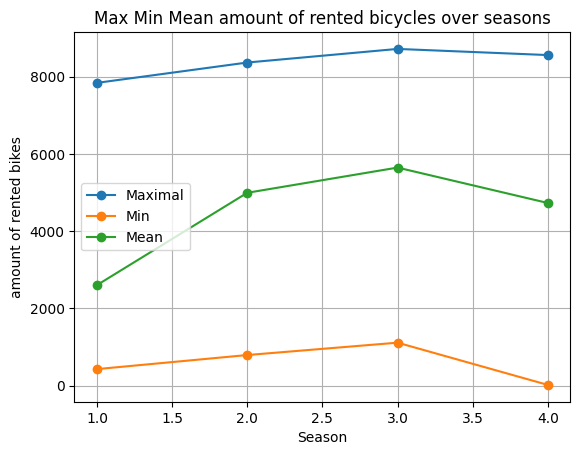

In [7]:
#season diagram
seasons_rent = content.groupby(by = "season").agg({"cnt": ["sum", "max","min", "mean"]})

seasons_rent.reset_index(inplace=True)
seasons_rent.columns = ["season","rent_sum", "rent_max","rent_min", "rent_mean"]


plt.plot(seasons_rent["season"], seasons_rent["rent_max"], label = "Maximal", marker = "o" )
plt.plot(seasons_rent["season"], seasons_rent["rent_min"], label = "Min", marker = "o" )
plt.plot(seasons_rent["season"], seasons_rent["rent_mean"], label = "Mean", marker = "o" )


plt.title("Max Min Mean amount of rented bicycles over seasons")

plt.xlabel("Season")
plt.ylabel("amount of rented bikes")
plt.legend()
plt.grid(True)
plt.show()


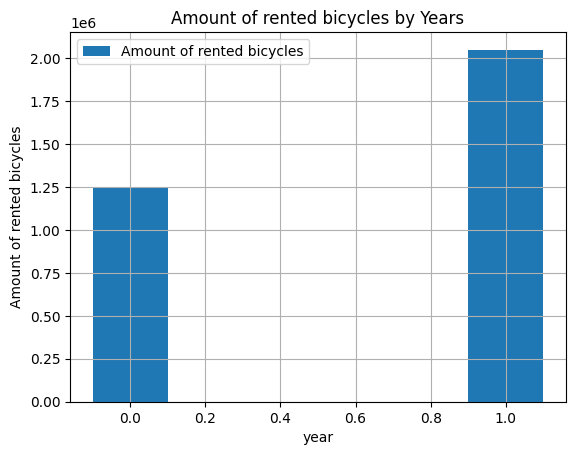

In [37]:
#year
year_rent = content.groupby(by = "yr").agg({"cnt": ["sum"]})
year_rent.reset_index(inplace = True)
year_rent.columns = ["year","rent_amount"]

plt.bar(year_rent["year"], year_rent["rent_amount"], label = "Amount of rented bicycles", width=0.2)

plt.xlabel("year")
plt.ylabel("Amount of rented bicycles")

plt.title("Amount of rented bicycles by Years")
plt.legend()
plt.grid(True)
plt.show()


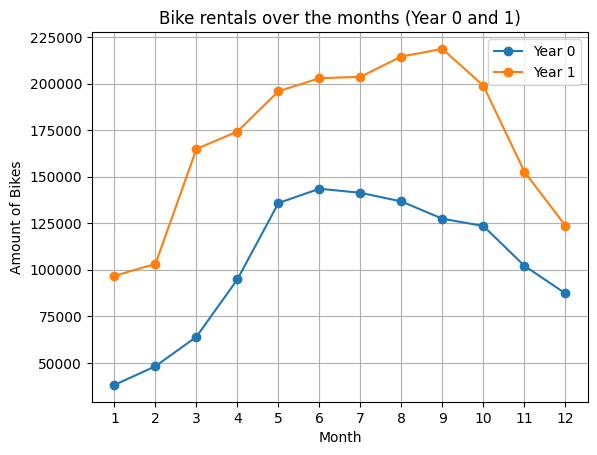

In [9]:

#month
month_rent = content.groupby(by = ["yr", "mnth"]).agg({"cnt": ["sum"]})
month_rent.reset_index(inplace=True)
month_rent.columns = ["year","month","amount of bikes"]
year_0 = month_rent[month_rent["year"]==0]
year_1 = month_rent[month_rent["year"]==1]

plt.plot(year_0["month"],year_0["amount of bikes"],label = "Year 0", marker = "o")
plt.plot(year_1["month"], year_1["amount of bikes"], label = "Year 1", marker='o')

plt.title("Bike rentals over the months (Year 0 and 1)")
plt.xlabel("Month")
plt.ylabel("Amount of Bikes")
plt.xticks(range(1,13))
plt.grid(True)
plt.legend()
plt.show()

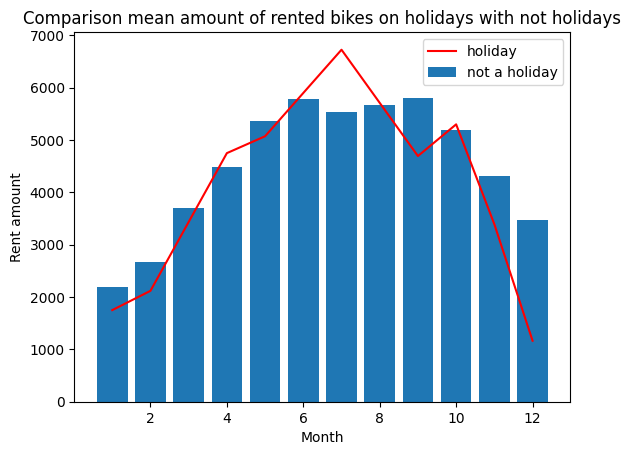

In [10]:
#holiday
holiday_rent = content.groupby(by = ["mnth", "holiday"]).agg({"cnt": ["mean"]})
holiday_rent.reset_index(inplace=True)
holiday_rent
holiday_rent.columns = ["month","holiday", "amount"]
not_holiday_rent = holiday_rent[holiday_rent["holiday"] == 0]
holiday_rent = holiday_rent[holiday_rent["holiday"] == 1]

plt.bar(not_holiday_rent["month"],not_holiday_rent["amount"], label="not a holiday")
plt.plot(holiday_rent["month"],holiday_rent["amount"], label="holiday", color="red")

plt.xlabel("Month")
plt.ylabel("Rent amount")
plt.title("Comparison mean amount of rented bikes on holidays with not holidays")
plt.legend()
plt.show()

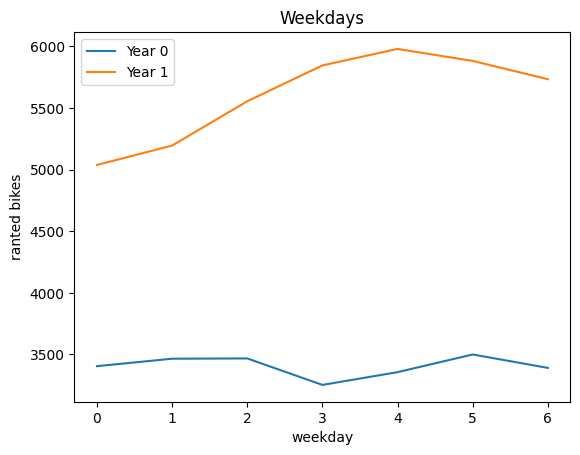

In [11]:
#weekday
weekday_rent = content.groupby(by = ["yr", "weekday"]).agg({"cnt": ["mean"]})
weekday_rent.reset_index(inplace=True)

weekd_0 = weekday_rent[weekday_rent["yr"] == 0]
weekd_1 = weekday_rent[weekday_rent["yr"]== 1]

plt.plot(weekd_0["weekday"], weekd_0["cnt"], label="Year 0")
plt.plot(weekd_1["weekday"],weekd_1["cnt"], label="Year 1")

plt.xlabel("weekday")
plt.ylabel("ranted bikes")
plt.legend()
plt.title("Weekdays")
plt.show()

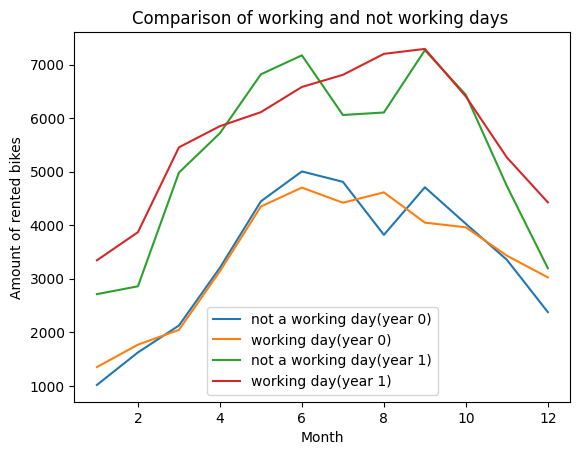

In [12]:
#workingday
workingday_rent = content.groupby(by = ["yr", "mnth", "workingday"]).agg({"cnt": ["mean"]})
workingday_rent.reset_index(inplace=True)

wd_year0_0 = workingday_rent[(workingday_rent["yr"] == 0) & (workingday_rent["workingday"] == 0)]
wd_year0_1 = workingday_rent[(workingday_rent["yr"] == 0) & (workingday_rent["workingday"] == 1)]

wd_year1_0 = workingday_rent[(workingday_rent["yr"] == 1) & (workingday_rent["workingday"] == 0)]
wd_year1_1 = workingday_rent[(workingday_rent["yr"] == 1) & (workingday_rent["workingday"] == 1)]


plt.plot(wd_year0_0["mnth"], wd_year0_0["cnt"], label="not a working day(year 0)")
plt.plot(wd_year0_1["mnth"], wd_year0_1["cnt"],  label="working day(year 0)")

plt.plot(wd_year1_0["mnth"], wd_year1_0["cnt"], label="not a working day(year 1)")
plt.plot(wd_year1_1["mnth"], wd_year1_1["cnt"],  label="working day(year 1)")

plt.legend()
plt.title("Comparison of working and not working days ")
plt.xlabel("Month")
plt.ylabel("Amount of rented bikes")

plt.show()


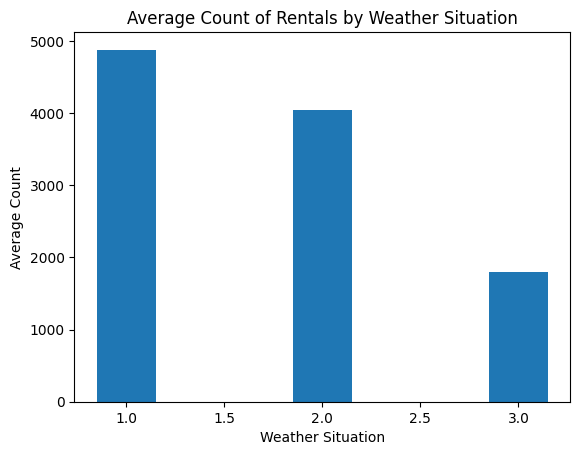

In [38]:
#weathersit
weather = content.groupby(by = ["weathersit"]).agg({"cnt": ["mean"]})
weather.reset_index(inplace=True)
weather.columns = weather.columns.get_level_values(0)

plt.bar(weather["weathersit"], weather["cnt"], width=0.3)

plt.xlabel("Weather Situation")
plt.ylabel("Average Count")
plt.title("Average Count of Rentals by Weather Situation")
plt.show()

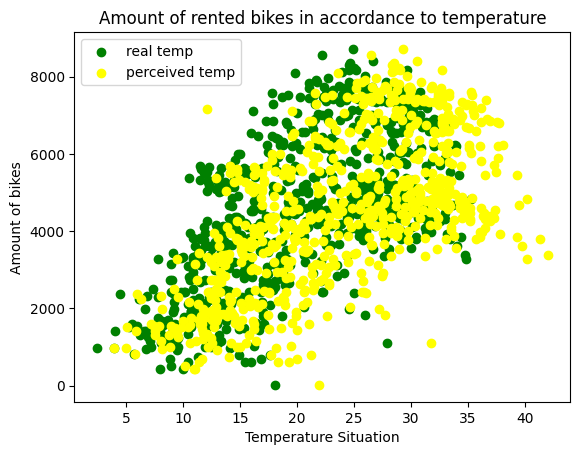

In [14]:
#temp and atemp
temperature = content[["temp", "atemp", "cnt"]]

plt.scatter(temperature["temp"], temperature["cnt"], color="green", label = "real temp")
plt.scatter(temperature["atemp"], temperature["cnt"], color="yellow", label = "perceived temp")

plt.xlabel("Temperature Situation")
plt.ylabel("Amount of bikes")
plt.title("Amount of rented bikes in accordance to temperature")
plt.legend()
plt.show()

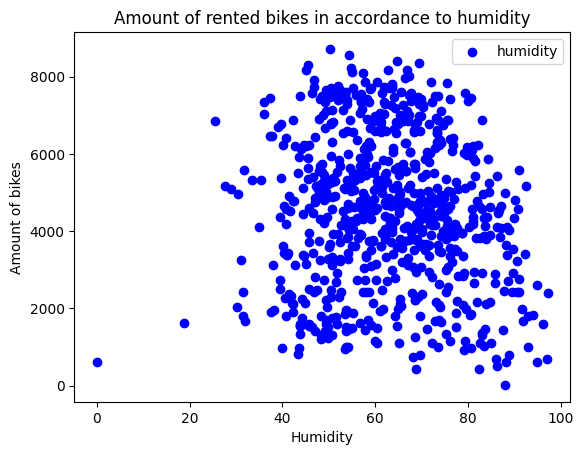

In [15]:
#humidity
hum_wind = content[["hum", "cnt"]]

plt.scatter(hum_wind["hum"], hum_wind["cnt"], color="blue", label = "humidity")


plt.xlabel("Humidity")
plt.ylabel("Amount of bikes")
plt.title("Amount of rented bikes in accordance to humidity")
plt.legend()
plt.show()

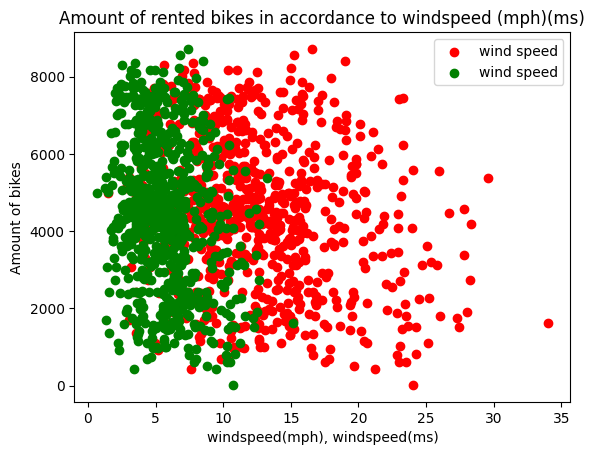

In [16]:
#windspeed
wind = content[["windspeed(mph)", "windspeed(ms)", "cnt"]]

plt.scatter(wind["windspeed(mph)"], wind["cnt"], color="red", label = "wind speed")
plt.scatter(wind["windspeed(ms)"], wind["cnt"], color="green", label = "wind speed")

plt.xlabel("windspeed(mph), windspeed(ms)")
plt.ylabel("Amount of bikes")
plt.title("Amount of rented bikes in accordance to windspeed (mph)(ms)")
plt.legend()
plt.show()

__Запитання:__
1. Яким є характер залежності кількості прокатів від місяця?
1. Вкажіть одну або дві ознаки, від яких кількість прокатів скоріше за все залежить лінійно.

In [17]:
'''
Ответы:
1. Зависимость не является линейной,это больше указывает на сезонные колебания, но не напрямую зависимость между этими величинами.

2. Среди указанных графиков, возможно рассмотреть линейную зависимость роста количества арендованных велосипедов от года 0 к году 1,
чтo отображено на графике "Amount of rented bicycles by Years";
 также линейное зависимость просматривается на графике зависимости температуры от количества арендованных велосипедов,
чтo отображено на графике "Average Count of Rentals by Weather Situation"'''

'\nОтветы:\n1. Зависимость не является линейной,это больше указывает на сезонные колебания, но не напрямую зависимость между этими величинами.\n\n2. Среди указанных графиков, возможно рассмотреть линейную зависимость роста количества арендованных велосипедов от года 0 к году 1,\nчтo отображено на графике "Amount of rented bicycles by Years";\n также линейное зависимость просматривается на графике зависимости температуры от количества арендованных велосипедов,\nчтo отображено на графике "Average Count of Rentals by Weather Situation"'

## Завдання 2

Давайте більш строго оцінимо рівень лінійної залежності між ознаками та цільовою змінною. Гарною мірою лінійної залежності між двома векторами є кореляція Пірсона. Нам уже доводилося мати з нею справу раніше. Для її обчислення в pandas можна використовувати методи датафрейму: corr і corrwith.

Порахуйте кореляції всіх ознак, окрім останньої, з останньою за допомогою методу `corrwith`.

In [18]:
# Pearson correlation

pearson = content.iloc[:, :-1].corrwith(content.iloc[:, -1])

print("Pearson correlation: ", "\n", pearson)

Pearson correlation:  
 season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
dtype: float64


У вибірці є ознаки, що корелюють із цільовою, а отже, завдання можна розв'язувати лінійними методами.

За графіками видно, що деякі ознаки схожі між собою. Тому давайте також порахуємо кореляції між речовими ознаками.

## Завдання 3

Порахуйте попарні кореляції між ознаками temp, atemp, hum, windspeed(mph), windspeed(ms) і cnt
за допомогою методу corr:

In [19]:
# Порахуйте попарні кореляції між ознаками temp, atemp, hum, windspeed(mph), windspeed(ms) і cnt за допомогою методу corr:
subset = content[["temp", "atemp", "hum", "windspeed(mph)", "windspeed(ms)", "cnt"]]
pairweise_correlation = subset.corr()
print(pairweise_correlation)

                    temp     atemp       hum  windspeed(mph)  windspeed(ms)  \
temp            1.000000  0.991702  0.126963       -0.157944      -0.157944   
atemp           0.991702  1.000000  0.139988       -0.183643      -0.183643   
hum             0.126963  0.139988  1.000000       -0.248489      -0.248489   
windspeed(mph) -0.157944 -0.183643 -0.248489        1.000000       1.000000   
windspeed(ms)  -0.157944 -0.183643 -0.248489        1.000000       1.000000   
cnt             0.627494  0.631066 -0.100659       -0.234545      -0.234545   

                     cnt  
temp            0.627494  
atemp           0.631066  
hum            -0.100659  
windspeed(mph) -0.234545  
windspeed(ms)  -0.234545  
cnt             1.000000  


На діагоналях, як і належить, стоять одиниці. Однак у матриці є ще дві пари сильно корелюючих стовпців: temp і atemp (корелюють за своєю природою) і два windspeed (тому що це просто переведення одних одиниць в інші). Далі ми побачимо, що цей факт негативно позначається на навчанні лінійної моделі.

Насамкінець подивимося середні ознак (метод mean), щоб оцінити масштаб ознак і частки 1 у бінарних ознак.

## Завдання 4

Виведіть середні ознак.

In [20]:
# Виведіть середні ознак.
content.mean()[1:]

,0
yr,0.500684
mnth,6.519836
holiday,0.028728
weekday,2.997264
workingday,0.683995
weathersit,1.395349
temp,20.310776
atemp,23.717699
hum,62.789406
windspeed(mph),12.762576


Ознаки мають різний масштаб, отже, для подальшої роботи нам краще нормувати матрицю об'єкти-ознаки.

### Проблема перша: колінеарні ознаки

Отже, у наших даних одна ознака дублює іншу, і є ще дві дуже схожі. Звичайно, ми могли б одразу видалити дублікати, але давайте подивимося, як відбувалося б навчання моделі, якби ми не помітили цю проблему.

Для початку проведемо масштабування, або стандартизацію ознак: з кожної ознаки віднімемо її середнє і поділимо на стандартне відхилення. Це можна зробити за допомогою методу scale.

Крім того, необхідно перемішати вибірку, це буде потрібно для крос-валідації.

In [21]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [22]:
df_shuffled = shuffle(df, random_state=42)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

Давайте навчимо лінійну регресію на наших даних і подивимося на ваги ознак.

In [23]:
from sklearn.linear_model import LinearRegression

## Завдання 5

Створіть об'єкт лінійного регресора, навчіть його на всіх даних і виведіть ваги моделі (ваги зберігаються у змінній `coef_` класу регресора). Можна виводити пари (назва ознаки, вага), скориставшись функцією `zip`, вбудованою в мову python. Назви ознак зберігаються у змінній `df.columns`.


In [24]:
regressor = LinearRegression().fit(X,y)

for i,v in zip(df.columns, regressor.coef_):
  print(f"{i}: {v:.2f}")

season: 570.86
yr: 1021.97
mnth: -141.30
holiday: -86.76
weekday: 137.23
workingday: 56.39
weathersit: -330.23
temp: 367.48
atemp: 585.55
hum: -145.61
windspeed(mph): 12457138390688.88
windspeed(ms): -12457138390887.35


Ми бачимо, що ваги при лінійно-залежних ознаках за модулем значно більші, ніж при інших ознаках. Щоб зрозуміти, чому так сталося, згадаємо аналітичну формулу, за якою обчислюються ваги лінійної моделі в методі найменших квадратів:

$$w = (X^TX)^{-1} X^T y$$

Якщо в $X$ є колінеарні (лінійно-залежні) стовпці, матриця $X^TX$ стає виродженою, і формула перестає бути коректною. Чим більш залежні ознаки, тим менший визначник цієї матриці й тим гірша апроксимація $Xw \approx y$. Таку ситуацію називають _проблемою мультиколінеарності_.

З парою (temp, atemp) трохи менше корелюючих змінних такого не сталося, однак на практиці завжди варто уважно стежити за коефіцієнтами при схожих ознаках.

Для того щоб розв'язати проблему мультиколінеарності, потрібно скористатися регуляризатором. До оптимізуючого функціоналу додають $L_1$ або $L_2$ норму ваг, помножену на коефіцієнт регуляризації $\alpha$. У першому випадку метод називається Lasso, а у другому — Ridge.

### Завдання 6
Давайте спробуємо навчити лінійні моделі з $L_1$ і $L_2$-регуляризацією, а далі порівняємо їхні ваги. Навчіть регресори Ridge і Lasso з параметрами за замовчуванням і переконайтеся, що проблема з вагами вирішилась.

Навчіть лінійну модель з $L_1$-регуляризацією (клас Lasso) і виведіть ваги.

In [25]:
# клас Lasso
from sklearn.linear_model import Lasso

lasso = Lasso().fit(X,y)

for i,v in zip(content.columns, lasso.coef_):
  print(f"{i}: {v}")


season: 560.2416160308861
yr: 1019.4634940657196
mnth: -128.73062703678696
holiday: -86.15278133371106
weekday: 137.34789390496314
workingday: 55.21237064135668
weathersit: -332.3698569623487
temp: 376.3632362096943
atemp: 576.530793504555
hum: -144.12915500348583
windspeed(mph): -197.1396894024843
windspeed(ms): -2.8051404183533485e-08


Навчіть лінійну модель з $L_2$-регуляризацією (клас Ridge) і виведіть ваги.

In [26]:
# клас Ridge
from sklearn.linear_model import Ridge

ridge = Ridge().fit(X,y)

for i,v in zip(content.columns, ridge.coef_):
  print(f"{i}: {v}")

season: 563.0645722520181
yr: 1018.9483787875305
mnth: -131.87332028247715
holiday: -86.74609799709232
weekday: 138.00511117871918
workingday: 55.90311037506467
weathersit: -332.34978849907367
temp: 386.45788919190807
atemp: 566.3470470600669
hum: -145.07132729867195
windspeed(mph): -99.25944108179067
windspeed(ms): -99.25944115434177


### Завдання 7

На відміну від $L_2$-регуляризації, $L_1$ обнуляє ваги при деяких ознаках. Давайте поспостерігаємо, як змінюються ваги зі збільшенням коефіцієнта регуляризації $\alpha$.

Для кожного значення коефіцієнта з `alphas` навчіть регресор `Lasso` і запишіть ваги у список `coefs_lasso`, а потім навчіть `Ridge` і запишіть ваги у список`coefs_ridge`. Конвертуйте отримані списки в `np.array`.

In [27]:
alphas = np.arange(1, 500, 50)

coefs_lasso = list()
coefs_ridge = list()

for alpha in alphas:
    lasso= Lasso(alpha=alpha).fit(X,y)
    ridge=Ridge(alpha=alpha).fit(X,y)
    coefs_lasso.append(lasso.coef_)
    coefs_ridge.append(ridge.coef_)

coefs_lasso = np.round(np.array(coefs_lasso), 2)
coefs_ridge= np.round(np.array(coefs_ridge), 2)

print("Lasso regularisation: ", "\n", coefs_lasso, "\n")
print("Ridge regularisation: ", "\n", coefs_ridge)


Lasso regularisation:  
 [[ 560.24 1019.46 -128.73  -86.15  137.35   55.21 -332.37  376.36  576.53
  -144.13 -197.14   -0.  ]
 [ 410.97  977.02   -0.    -53.45   91.94   17.54 -318.13  322.83  610.03
   -91.07 -145.07   -0.  ]
 [ 370.08  935.95    0.    -12.16   48.89    0.   -308.81  269.42  632.5
   -27.5   -93.77   -0.  ]
 [ 332.84  891.87    0.     -0.      0.      0.   -279.62  211.05  662.92
    -0.    -50.16   -0.  ]
 [ 298.13  845.65    0.     -0.      0.      0.   -235.57  124.14  725.38
    -0.    -12.65   -0.  ]
 [ 258.93  799.24    0.     -0.      0.      0.   -190.82   72.08  750.36
    -0.     -0.     -0.  ]
 [ 217.43  752.72    0.     -0.      0.      0.   -145.71   37.72  756.3
    -0.     -0.     -0.  ]
 [ 175.93  706.2     0.     -0.      0.      0.   -100.61    3.66  761.93
    -0.     -0.     -0.  ]
 [ 134.63  659.63    0.     -0.      0.      0.    -55.51    0.    737.35
    -0.     -0.     -0.  ]
 [  93.35  613.05    0.     -0.      0.      0.    -10.42    0.    7

Проаналізуйте динаміку ваг при збільшенні параметра регуляризації:

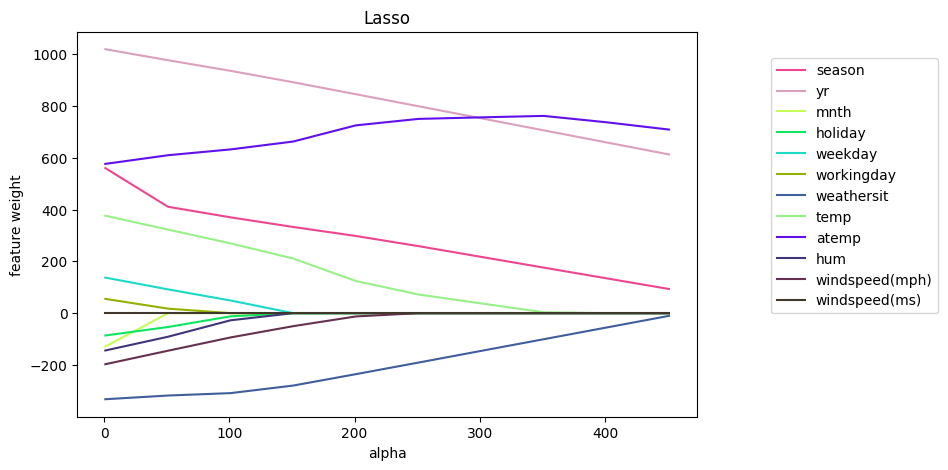

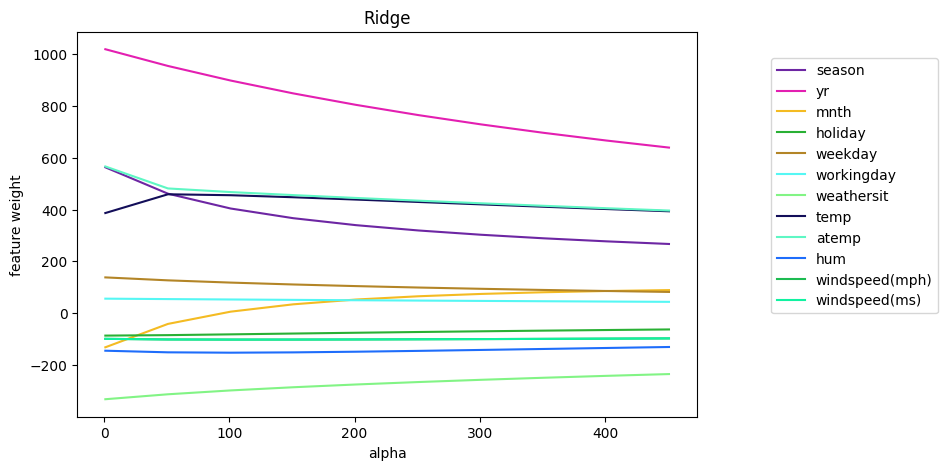

In [28]:
plt.figure(figsize=(8, 5))

for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

plt.show()

Проаналізуйте графіки та дайте відповіді на такі запитання.

1. Який регуляризатор (Ridge або Lasso) агресивніше зменшує ваги при одному й тому самому alpha?
1. Що станеться з вагами Lasso, якщо alpha зробити дуже великим? Поясніть, чому так відбувається.
1. Чи можна стверджувати, що `Lasso` виключає одну з ознак `windspeed` при будь-якому значенні `alpha > 0`? А Ridge? Вважається, що регуляризатор виключає ознаку, якщо коефіцієнт при ньому менший $10^{-3}$.
1. Який із регуляризаторів підійде для відбору неінформативних ознак?

In [29]:
"""
1. Более агрессивным является является Lasso
2. Если сильно увеличить alpha то некоторые веса(наименее значимые) просто обнуляться, так как модель пытается минимизировать функцию ошибки c сильным штрафом за любые не нулевые веса.
Фактически Lasso является механизмом для отбора признаков. Если признак имеет слабое влияние на целевую переменную то его вес будет обновлён при высоком значении alpha.
3. Lasso - да; Ridge - нет.
4. Для отбора не информативных характеристик подойдёт Lasso, так как он, c увеличением alpha, обнуляет веса, признаки которых имеют наименьшее влияние на целевую переменную.
"""

'\n1. Более агрессивным является является Lasso\n2. Если сильно увеличить alpha то некоторые веса(наименее значимые) просто обнуляться, так как модель пытается минимизировать функцию ошибки c сильным штрафом за любые не нулевые веса.\nФактически Lasso является механизмом для отбора признаков. Если признак имеет слабое влияние на целевую переменную то его вес будет обновлён при высоком значении alpha.\n3. Lasso - да; Ridge - нет.\n4. Для отбора не информативных характеристик подойдёт Lasso, так как он, c увеличением alpha, обнуляет веса, признаки которых имеют наименьшее влияние на целевую переменную.\n'

### Завдання 8

Далі будемо працювати з `Lasso`.

Отже, ми бачимо, що при зміні alpha модель по-різному підбирає коефіцієнти ознак. Нам потрібно вибрати найкраще alpha.

Для цього, по-перше, нам потрібна метрика якості. Будемо використовувати як метрику сам оптимізований функціонал методу найменших квадратів, тобто `Mean Square Error`.

По-друге, потрібно зрозуміти, на яких даних цю метрику рахувати. Не можна вибирати `alpha` за значенням MSE на навчальній вибірці, тому що тоді ми не зможемо оцінити, як модель буде робити передбачення на нових для неї даних. Якщо ми виберемо одне розбиття вибірки на навчальну та тестову (це називається holdout), то налаштуємося на конкретні "нові" дані, і знову можемо перенавчитися. Тому будемо робити декілька розбиттів вибірки, на кожному пробувати різні значення alpha, а потім усереднювати MSE. Найзручніше робити такі розбиття крос-валідацією, тобто розділити вибірку на $K$ частин, і кожного разу брати одну з них як тестову, а з блоків, що залишилися, складати навчальну вибірку.

Робити крос-валідацію для регресії в sklearn зовсім просто: для цього є спеціальний регресор, __LassoCV__, який бере на вхід список із alpha і для кожного з них обчислює MSE на крос-валідації. Після навчання (якщо залишити параметр cv=3 за замовчуванням) регресор буде містити змінну __mse\_path\___, матрицю розміру len(alpha) x k, k = 3 (число блоків у крос-валідації), що містить значення MSE на тесті для відповідних запусків. Крім того, у змінній alpha\_ буде зберігатися вибране значення параметра регуляризації, а в coef\_, традиційно, навчені ваги, що відповідають цьому alpha_.

Зверніть увагу, що регресор може змінювати порядок, у якому він проходить по alphas; для зіставлення з матрицею MSE краще використовувати змінну регресора alphas_.

Навчіть регресор `LassoCV` на всіх параметрах регуляризації з alpha. Побудуйте графік _усередненого_ за рядками `MSE` в залежності від `alpha` (використовуйте для цього функцію `create_plot`).

Виведіть вибране `alpha`, а також пари "ознака-коефіцієнт" для навченого вектора коефіцієнтів.

In [30]:
def create_plot(data, title, xlabel, ylabel, figsize=None):
    size = figsize or (15, 5)
    plt.figure(figsize=size)


    x = list(map(lambda e: e[0], data))
    y = list(map(lambda e: e[1], data))

    plt.plot(x, y)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.grid()
    plt.show()

Optimal alpha =  6 

Model coefficients with optimal alpha: 
season: 532.019
yr: 1015.060
mnth: -100.040
holiday: -83.294
weekday: 132.504
workingday: 51.557
weathersit: -330.560
temp: 370.680
atemp: 581.397
hum: -140.007
windspeed(mph): -191.771
windspeed(ms): -0.000

 MSE: 
[[830768.68693702 919721.93589263 805481.54522903]
 [822965.9041311  911867.54470864 804343.02766964]
 [815129.08593972 903855.55058088 803483.74706927]
 [807667.98224742 896148.95236924 802906.09265381]
 [800137.23263318 888747.72399201 801974.9311743 ]
 [793005.6616591  881651.8631318  800937.92121214]
 [786275.36724172 874861.36810104 799342.37031522]
 [779946.35004807 868376.23749144 798151.12777192]
 [774018.6100807  862196.47012638 797363.63293845]
 [768492.14733962 856322.06502308 796979.89551936]
 [763366.96182482 850359.8722302  796999.92588656]
 [758643.05353631 844566.95589129 797423.73295863]
 [754320.42247408 839080.96310802 798251.32439694]
 [750399.06863813 833901.906581   799482.70678255]
 [746878.

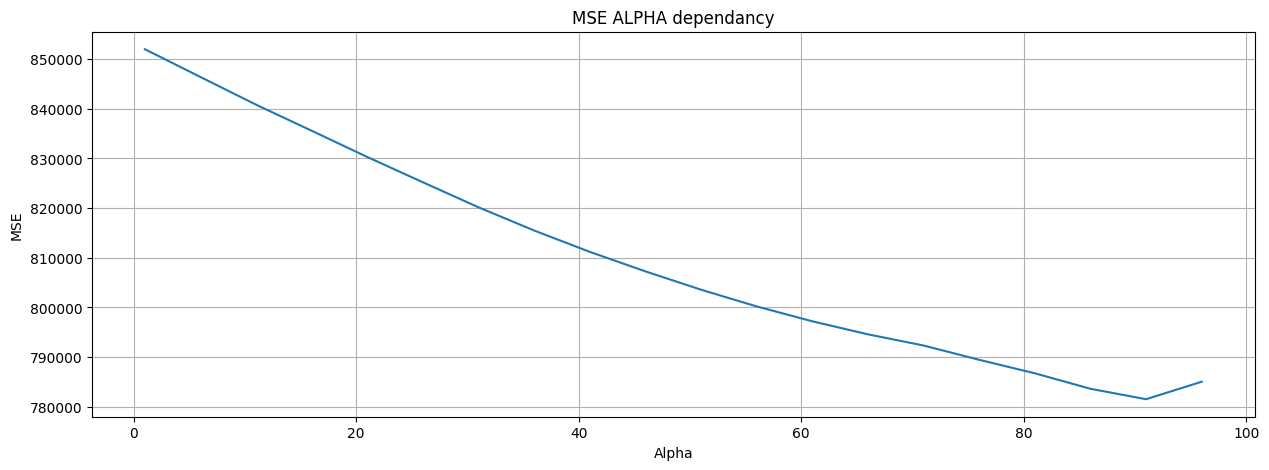

In [31]:
from sklearn.linear_model import LassoCV

alphas = np.arange(1, 100, 5)

regressor = LassoCV(alphas=alphas, cv=3)
regressor.fit(X,y)


print("Optimal alpha = ",regressor.alpha_, "\n")
print("Model coefficients with optimal alpha: ")
for i, v in zip(content.columns, regressor.coef_):
  print(f"{i}: {v:.3f}")
print("\n", "MSE: ")
print(regressor.mse_path_)

mse_list=np.round(regressor.mse_path_.mean(axis=1), 2)

data = [[alpha, mse] for alpha, mse in zip(alphas, mse_list)]

title = "MSE ALPHA dependancy"
xlabel="Alpha"
ylabel="MSE"


create_plot(data, title, xlabel, ylabel)

Отже, ми вибрали певний параметр регуляризації. Давайте подивимося, які б ми вибирали alpha, якби ділили вибірку лише один раз на навчальну та тестову, тобто розглянемо траєкторії MSE, що відповідають окремим блокам вибірки.

### Завдання 9

Виведіть значення `alpha`, що відповідають мінімумам `MSE` на кожному розбитті (тобто за стовпцями).
На трьох окремих графіках візуалізуйте стовпці `mse_path_`.


Alphas according to the each Fold MSE minimum: [91, 96, 46] 



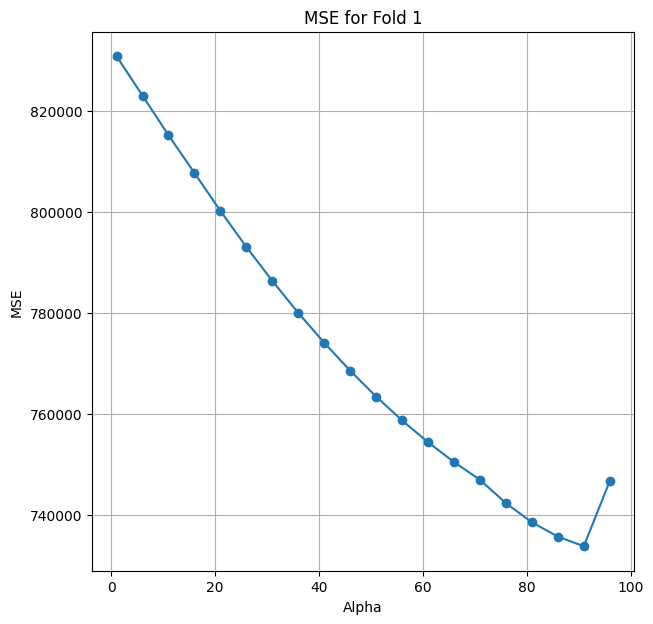

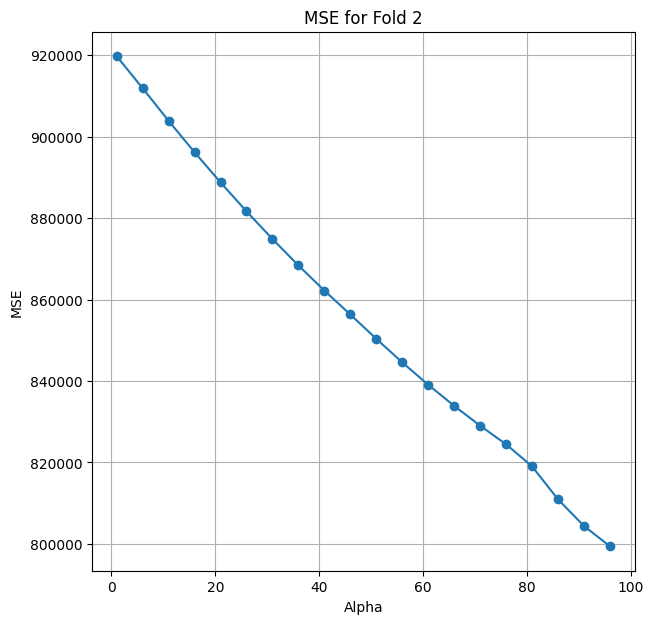

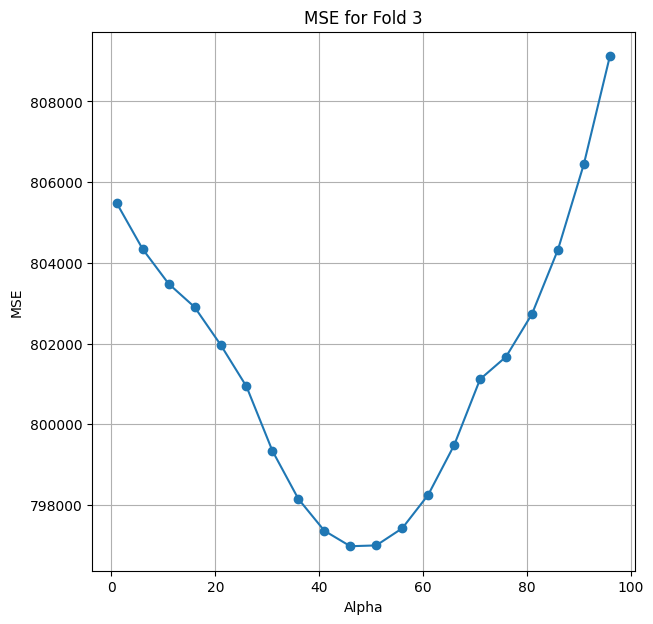

In [32]:
alpha_min_collumn = [alphas[i] for i in np.argmin(regressor.mse_path_, axis=0)]

print("Alphas according to the each Fold MSE minimum:", alpha_min_collumn, "\n")

#diagramms of MSE for each Fold
for i in range(3):
  plt.figure(figsize=(7,7))
  plt.plot(alphas, regressor.mse_path_[:, i], marker="o")
  plt.xlabel("Alpha")
  plt.ylabel("MSE")
  plt.title(f"MSE for Fold {i+1}")
  plt.grid(True)
  plt.show()

На кожному розбитті оптимальне значення `alpha` своє, і йому відповідає велике MSE на інших розбиттях. Виходить, що ми налаштовуємося на конкретні навчальні та контрольні вибірки. При виборі `alpha` на крос-валідації ми вибираємо дещо "середнє", що даватиме прийнятне значення метрики на різних розбиттях вибірки.

### Завдання 10

Нарешті, як прийнято в аналізі даних, давайте проінтерпретуємо результат. Дайте відповіді на наступні запитання.

#### Запитання 1

В останній навченій моделі виберіть 4 ознаки з найбільшими (позитивними) коефіцієнтами (і випишіть їх), подивіться на візуалізації залежностей `cnt` від цих ознак, які ми зображали у блоці "Ознайомлення з даними". Чи видно зростаючу лінійну залежність `cnt` від цих ознак за графіками? Чи логічно стверджувати (виходячи зі здорового глузду), що чим більше значення цих ознак, тим більше людей захочуть взяти велосипеди?

__Відповідь:__

In [33]:
'''
Перечисляю признаки с наибольшими позитивными коэффициентами:
yr: 1015.060, temp: 370.680, atemp: 581.397, season: 532.019
По всем этим признакам можно сказать что наблюдается положительная взаимосвязь между этими признаками и целевой переменной cnt, то есть с ростом этого признака растёт целевая переменная.
Логично будет утверждать что чем больше значение этих признаков тем больше людей захотят арендовать велосипеды.
'''

'\nПеречисляю признаки с наибольшими позитивными коэффициентами:\nyr: 1015.060, temp: 370.680, atemp: 581.397, season: 532.019\nПо всем этим признакам можно сказать что наблюдается положительная взаимосвязь между этими признаками и целевой переменной cnt, то есть с ростом этого признака растёт целевая переменная.\nЛогично будет утверждать что чем больше значение этих признаков тем больше людей захотят арендовать велосипеды.\n'

#### Запитання 2

Виберіть 3 ознаки з найбільшими за модулем негативними коефіцієнтами (і випишіть їх), подивіться на відповідні візуалізації. Чи видно лінійну залежність, що зменшується? Чи логічно стверджувати, що чим більша величина цих ознак, тим менше людей захочуть взяти велосипеди?

__Відповідь:__

In [34]:

'''Ниже перечислены признаки с наибольшим по модулю отрицательным значением:
weathersit: -330.560
hum: -140.007
windspeed(mph): -191.771
Логично будет утверждать что чем больше величина этих признаков тем меньше людей захотят взять в аренду велосипеды, что также подтверждаются
Жизненной логикой, при которой чем больше ветер чем больше влажность тем хуже температура тем меньше людей готовы брать велосипед в аренду.
'''

'Ниже перечислены признаки с наибольшим по модулю отрицательным значением:\nweathersit: -330.560\nhum: -140.007\nwindspeed(mph): -191.771\nЛогично будет утверждать что чем больше величина этих признаков тем меньше людей захотят взять в аренду велосипеды, что также подтверждаются\nЖизненной логикой, при которой чем больше ветер чем больше влажность тем хуже температура тем меньше людей готовы брать велосипед в аренду.\n'

#### Запитання 3

Випишіть ознаки з коефіцієнтами, близькими до нуля (< 1e-3). Як ви думаєте, чому модель виключила їх із моделі (знову подивіться на графіки)? Чи правда, що вони ніяк не впливають на попит на велосипеди?

__Відповідь:__

In [35]:
'''Признак, который модель обнулила:
windspeed(ms): -0.000
Это произошло в связи с тем, что при изменении(увелич либо уменьш) данного признака целевая переменная не меняется в соответствии с изменением данного признака.
То есть нет прямой корреляции между этими величинами. И на графике не просматривается зависимость между ними и целевой переменной.
Кроме того, этот же признак уже представлен в данной модели только называется по-другому windspeed(mph), kоторый модели не обнулила.
В связи с тем что эти два признака windspeed(mph) и windspeed(ms) представляют собой одно и то же, То эти два вектора коллинеарны(каждый из них можно выразить через другой)
и для модели это избыточное информация, kоторую Lasso обнуляет.
'''

'Признак, который модель обнулила:\nwindspeed(ms): -0.000\nЭто произошло в связи с тем, что при изменении(увелич либо уменьш) данного признака целевая переменная не меняется в соответствии с изменением данного признака.\nТо есть нет прямой корреляции между этими величинами. И на графике не просматривается зависимость между ними и целевой переменной.\nКроме того, этот же признак уже представлен в данной модели только называется по-другому windspeed(mph), kоторый модели не обнулила. \nВ связи с тем что эти два признака windspeed(mph) и windspeed(ms) представляют собой одно и то же, То эти два вектора коллинеарны(каждый из них можно выразить через другой)\nи для модели это избыточное информация, kоторую Lasso обнуляет.\n'

### Висновок
Отже, ми подивилися, як можна стежити за адекватністю лінійної моделі, як відбирати ознаки і як грамотно, за можливості не налаштовуючись на якусь конкретну порцію даних, підбирати коефіцієнт регуляризації.

Варто зазначити, що за допомогою крос-валідації зручно підбирати лише невелику кількість параметрів. (1, 2, максимум 3), тому що для кожної допустимої їх комбінації нам доводиться декілька разів навчати модель. Такий процес займає багато часу, особливо якщо треба навчатися на великих обсягах даних.